# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
sample_data = filtered_data.head(50000)

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

8.762033722951463

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [11]:
# Combining all the above stundents 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46072/46072 [00:21<00:00, 2120.51it/s]


In [12]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

In [0]:
final["Clean_text"] = preprocessed_reviews

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8247078061103821), ('fantastic', 0.8019644021987915), ('good', 0.8002786040306091), ('terrific', 0.7964109182357788), ('wonderful', 0.7728119492530823), ('excellent', 0.7681573629379272), ('amazing', 0.7567963600158691), ('perfect', 0.7198940515518188), ('fabulous', 0.7109171152114868), ('ideal', 0.6782199144363403)]
[('best', 0.7315809726715088), ('greatest', 0.7270729541778564), ('nastiest', 0.662599503993988), ('tastiest', 0.6460682153701782), ('awful', 0.6459751725196838), ('experienced', 0.6317474842071533), ('ive', 0.6218169927597046), ('disgusting', 0.6177241206169128), ('eaten', 0.6049336194992065), ('horrible', 0.6037015914916992)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'available', 'victor', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 46072/46072 [01:30<00:00, 511.67it/s]

46072
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

 33%|███▎      | 15381/46072 [05:36<12:33, 40.75it/s]

KeyboardInterrupt: ignored

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [0]:
# short final data based on time
final = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#split data in train, test and cv before using it to avoid data leakage
from sklearn.model_selection import train_test_split

X = final['Clean_text']
y = final['Score']

X_train,X_test,y_train_,y_test_ = train_test_split(X,y,test_size=.5,random_state=0,shuffle=False)
X_cv,X_test,y_cv_,y_test_ = train_test_split(X_test,y_test_,test_size=.5,random_state=0,shuffle=False)

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
#function to find an optimal value of k,AUC,ROC,confusion matrix
def model(x_train,x_cv,x_test,y_train,y_cv,y_test,reg):
    
    C = [{'C':[10**-4, 10**-2, 10**0, 10**2, 10**4]}]
    pred_cv = [] 
    pred_train = []
    opt_c = 0
    max_auc = -1
    
    for c in tqdm(C[0]['C']):
      clf = LogisticRegression(C=c,penalty=reg,class_weight = 'balanced')
      clf.fit(x_train,y_train)
      prob_cv = clf.predict_proba(x_cv)
      prob_tr = clf.predict_proba(x_train)
      prob_cv = prob_cv[:,1]
      prob_tr = prob_tr[:,1]
      auc_cv = roc_auc_score(y_cv,prob_cv)
      auc_tr = roc_auc_score(y_train,prob_tr)
      pred_cv.append(auc_cv)
      pred_train.append(auc_tr)
      if max_auc < auc_cv:
            max_auc = auc_cv
            opt_c = c
    
    print('opt c: ',opt_c)
    #AUC curve
    plt.plot(np.log(C[0]['C']),pred_cv,'r',label='CV')
    plt.plot(np.log(C[0]['C']),pred_train,'g',label='train')
    plt.legend(loc='upper right')
    plt.title('C vs AUC Score')
    plt.ylabel('AUC Score')
    plt.xlabel('C')
    plt.show()
    
    
    
def test(x_train,x_cv,x_test,y_train,y_cv,y_test,opt_c,reg):
    clf = LogisticRegression(C= opt_c,penalty=reg,class_weight = 'balanced')
    clf.fit(x_train,y_train)
    prob_test = clf.predict_proba(x_test)
    prob_test = prob_test[:,1]
    
    prob_train = clf.predict_proba(x_train)
    prob_train = prob_train[:,1]
    print("AUC Score: {}".format(roc_auc_score(y_test,prob_test)))
    
    #ROC curve
    fpr_tr,tpr_tr,thres_tr = roc_curve(y_train,prob_train)
    fpr,tpr,thres = roc_curve(y_test,prob_test)
    plt.plot([0,0],[1,1],linestyle='--')
    plt.plot(fpr,tpr,'r',marker='.',label='test')
    plt.plot(fpr_tr,tpr_tr,'b',marker='.',label='train')
    plt.legend(loc='upper right')
    plt.title("ROC curve")
    plt.show()
    
    #confusion matrix fortrain and test
    print("Confusion matrix for train data")
    predict_tr = clf.predict(x_train)
    confu_metrix_(y_train,predict_tr)
    
    print("Confusion matrix for test data")
    predict_te = clf.predict(x_test)
    confu_metrix_(y_test,predict_te)
    

def confu_metrix_(y,predict):
    confu_metrix = confusion_matrix(y,predict)
    confu_df = pd.DataFrame(confu_metrix,index=["-ve","+ve"],columns=["-ve","+ve"])
    sns.heatmap(confu_df,annot=True,fmt='d',cmap='viridis')
    plt.title("Confusion matrix")
    plt.xlabel("predicted label")
    plt.ylabel("True label")
    plt.show()

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [0]:
import pickle
bow_cv,bow_test,bow_train = pickle.load(open('bow.pkl','rb'))
y_cv,y_test,y_train = pickle.load(open('label.pkl','rb'))

100%|██████████| 5/5 [00:04<00:00,  1.19s/it]


opt c:  1


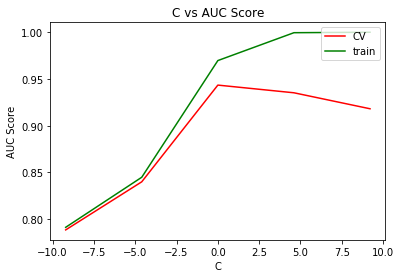

In [0]:
model(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,'l2')

AUC Score: 0.9380411030653437


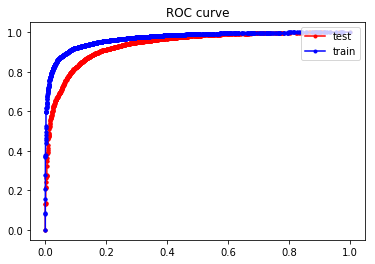

Confusion matrix for train data


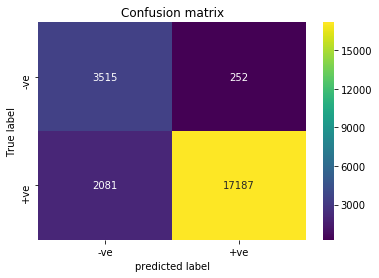

Confusion matrix for test data


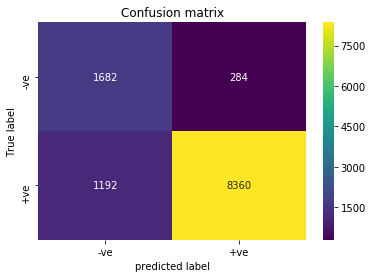

In [0]:
test(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,1,'l2')

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

opt c:  1


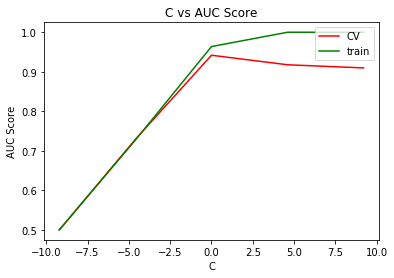

In [0]:
# Please write all the code with proper documentation
model(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,'l1')


AUC Score: 0.9369424958379555


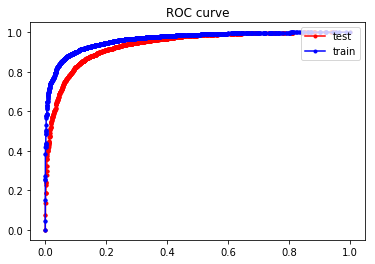

Confusion matrix for train data


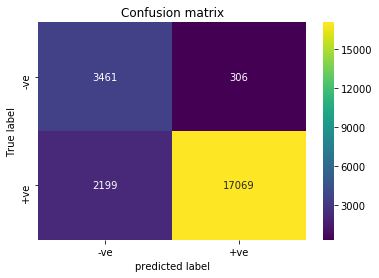

Confusion matrix for test data


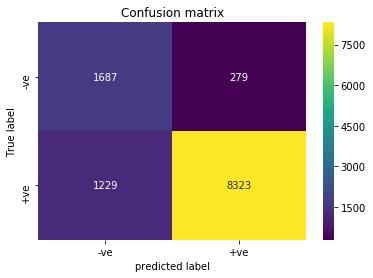

In [0]:
test(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,1,'l1')

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
def sparsity(x_train,y_train):
  C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
  non_zero = []
  lmbda= []
  for c in C:
    clf = LogisticRegression(C=c,penalty='l1',class_weight='balanced')
    clf.fit(x_train,y_train)
    non_zero.append(np.count_nonzero(clf.coef_))
    lmbda.append(1/c)
  print(non_zero)
  plt.plot(lmbda,non_zero,color = 'g',linewidth=2,linestyle='--')
  plt.title("lambda vs sparsity")
  plt.xlabel("Lambda")
  plt.ylabel("Non-zero values")
  plt.show()
    

[0, 4, 840, 4259, 5615]


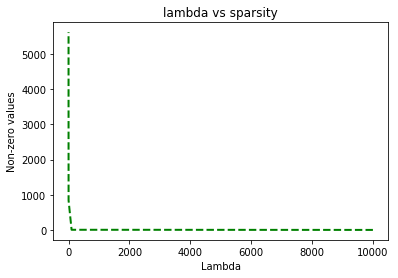

In [0]:
sparsity(bow_train,y_train)

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

100%|██████████| 5/5 [00:04<00:00,  1.17s/it]

opt c:  1


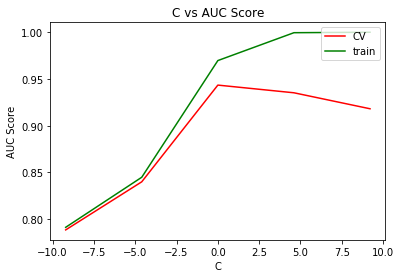

In [0]:
# Please write all the code with proper documentation
model(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,'l2')

AUC Score: 0.9380411030653437


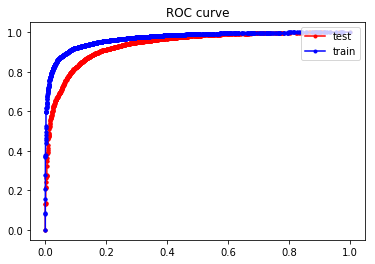

Confusion matrix for train data


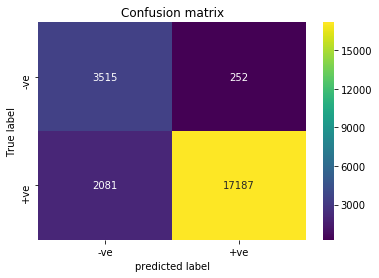

Confusion matrix for test data


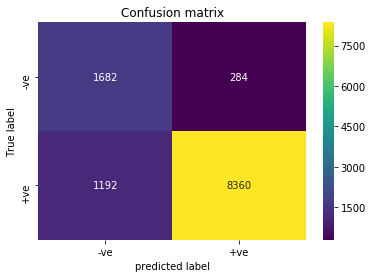

In [0]:
test(bow_train,bow_cv,bow_test,y_train,y_cv,y_test,1,'l2')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
bow_train.shape

(23035, 28368)

In [0]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=1,penalty='l2',class_weight='balanced')
clf.fit(bow_train,y_train)

w1 = clf.coef_

#new dataset
error = 0.01
new_bow_train= bow_train.astype(float)
new_bow_train.data += error


#train on new data and get the difference of the weight
clf = LogisticRegression(C=1,penalty='l2',class_weight='balanced')
clf.fit(new_bow_train,y_train)

w2 = clf.coef_

w1 += 10**-6
w2 += 10**-6

prcnt_chng = abs((w1-w2)/w1)*100

In [0]:
print(prcnt_chng)

[[1.23946546 0.11388784 4.21634964 ... 0.76653873 2.28657726 8.38998923]]


0 th percentile:  0.00020186978604989098
10 th percentile:  0.8695130010937013
20 th percentile:  1.7576627018197115
30 th percentile:  2.6113806612905566
40 th percentile:  3.5065163861111044
50 th percentile:  4.5743470623397275
60 th percentile:  5.819784640438062
70 th percentile:  7.474132278191803
80 th percentile:  10.007364183940213
90 th percentile:  15.689807996219383
100 th percentile:  11439.193256680728


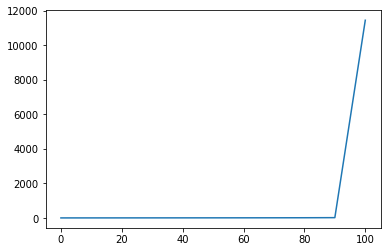

In [0]:
for i in range(0,101,10):
  print(i,'th percentile: ',np.percentile(prcnt_chng,i))

#plot the percentile change 
per = range(0,101,10)
plt.plot(per,np.percentile(prcnt_chng,per))

90 th percentile:  15.689807996219383
91 th percentile:  16.67844258663106
92 th percentile:  17.895592678982315
93 th percentile:  19.67493508187107
94 th percentile:  22.361937758518952
95 th percentile:  25.75732540993795
96 th percentile:  30.660204378048185
97 th percentile:  39.22690950899718
98 th percentile:  55.62622587145595
99 th percentile:  88.93555354299097
100 th percentile:  11439.193256680728


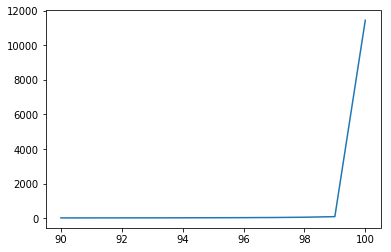

In [0]:
per = range(90,101,1)
for i in per:
  print(i,'th percentile: ',np.percentile(prcnt_chng,i))
  
plt.plot(per,np.percentile(prcnt_chng,per))

99 th percentile:  88.93555354299097
100 th percentile:  11439.193256680728


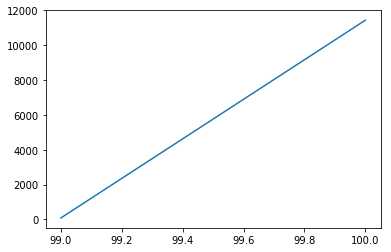

In [0]:
per = range(99,101,1)
for i in per:
  print(i,'th percentile: ',np.percentile(prcnt_chng,i))
  
plt.plot(per,np.percentile(prcnt_chng,per))

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

cnt_vec = CountVectorizer()
p = cnt_vec.fit_transform(X_train)

clf = LogisticRegression(C=1,penalty='l2',class_weight='balanced')
clf.fit(p,y_train_)
feat_log_prob = clf.coef_

p = pd.DataFrame(feat_log_prob.T,columns=['+ve'])
p["Feature"] = cnt_vec.get_feature_names()
p = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

In [0]:
print(p["Feature"][:10])

6613     delicious
18949      pleased
18458      perfect
1680       awesome
28622        yummy
11838       highly
2957        breath
807        amazing
4789          coat
22995    skeptical
Name: Feature, dtype: object


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
print(p["Feature"][-10:])

2487             bland
19157             poor
4247            chewed
7267        disgusting
6022          crunchie
7001              died
1684             awful
25433         terrible
7177     disappointing
28334            worst
Name: Feature, dtype: object


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 5/5 [00:05<00:00,  1.29s/it]

opt c:  10000


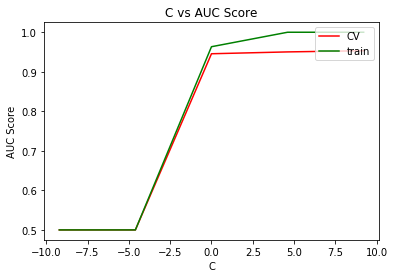

In [0]:
# Please write all the code with proper documentation
#import pickled tfidf object
tfidf_cv,tfidf_test,tfidf_train = pickle.load(open("tfidf.pkl",'rb'))

model(tfidf_train,tfidf_cv,tfidf_test,y_train,y_cv,y_test,'l1')

AUC Score: 0.9488801245972146


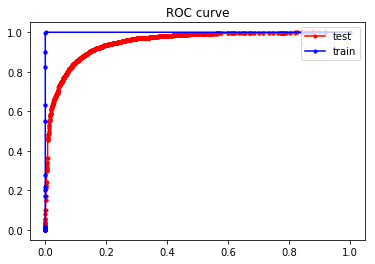

Confusion matrix for train data


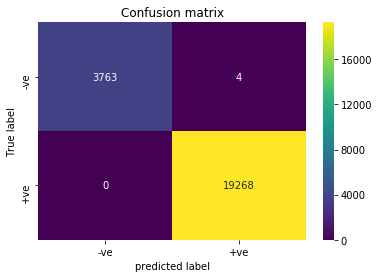

Confusion matrix for test data


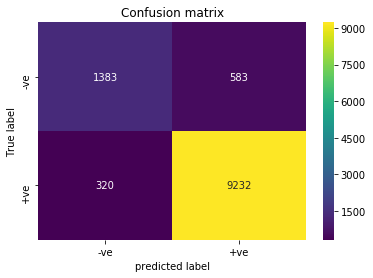

In [0]:
test(tfidf_train,tfidf_cv,tfidf_test,y_train,y_cv,y_test,10000,'l1')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 5/5 [00:08<00:00,  2.16s/it]


opt c:  100


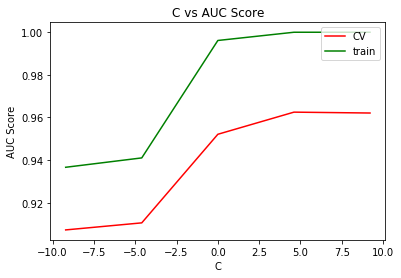

In [0]:
# Please write all the code with proper documentation
model(tfidf_train,tfidf_cv,tfidf_test,y_train,y_cv,y_test,'l2')

AUC Score: 0.9459927860734667


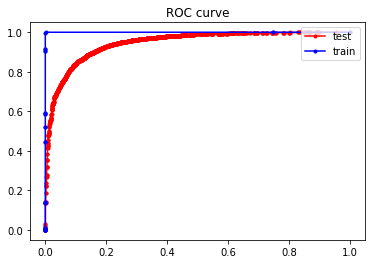

Confusion matrix for train data


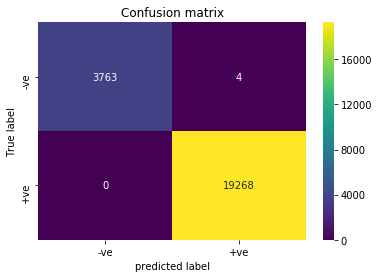

Confusion matrix for test data


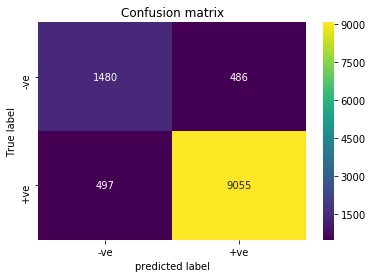

In [0]:
test(tfidf_train,tfidf_cv,tfidf_test,y_train,y_cv,y_test,100,'l1')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
tfidf_vec= TfidfVectorizer()
p = tfidf_vec.fit_transform(X_train)

clf = LogisticRegression(C=1,penalty='l2',class_weight='balanced')
clf.fit(p,y_train_)
feat_log_prob = clf.coef_

p = pd.DataFrame(feat_log_prob.T,columns=['+ve'])
p["Feature"] = tfidf_vec.get_feature_names()
p = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

In [0]:
print(p["Feature"][:10])

11015        great
6613     delicious
2269          best
10769         good
18458      perfect
14773         love
14782        loves
16743         nice
8773     excellent
11838       highly
Name: Feature, dtype: object


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation
print(p["Feature"][-10:])

2487             bland
16077            money
7177     disappointing
12062         horrible
26794    unfortunately
1684             awful
25433         terrible
7176      disappointed
28334            worst
16913              not
Name: Feature, dtype: object


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [17]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.7971819043159485), ('awesome', 0.7927252054214478), ('excellent', 0.7867019772529602), ('wonderful', 0.7824392914772034), ('fantastic', 0.7734043002128601), ('terrific', 0.746667742729187), ('perfect', 0.7393311858177185), ('amazing', 0.7284173965454102), ('decent', 0.7179358601570129), ('perky', 0.6693241596221924)]
[('best', 0.8207383751869202), ('tastiest', 0.7862836718559265), ('closest', 0.7447479963302612), ('nastiest', 0.7320988178253174), ('ive', 0.7286555171012878), ('ever', 0.6955010294914246), ('superior', 0.6935033798217773), ('eaten', 0.6880621910095215), ('softest', 0.6862406134605408), ('hooked', 0.681108832359314)]


In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9245
sample words  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'nothing', 'bother', 'link', 'top', 'page', 'buy']


In [0]:
# compute average word2vec for each review.
def vectorize_W2V(data):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(data): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

In [20]:
# vectorize all train,test and cv data
avg_w2v_train = vectorize_W2V(X_train)
avg_w2v_cv = vectorize_W2V(X_cv)
avg_w2v_test = vectorize_W2V(X_test)

100%|██████████| 11518/11518 [00:17<00:00, 659.08it/s]


100%|██████████| 5/5 [01:10<00:00, 16.05s/it]


opt c:  100


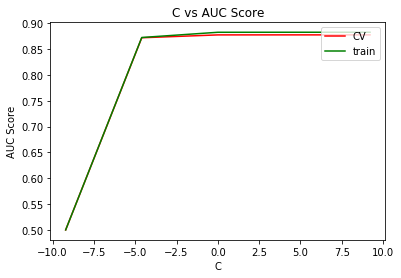

In [21]:
model(avg_w2v_train,avg_w2v_cv,avg_w2v_test,y_train_,y_cv_,y_test_,'l1')

AUC Score: 0.8911467940182082


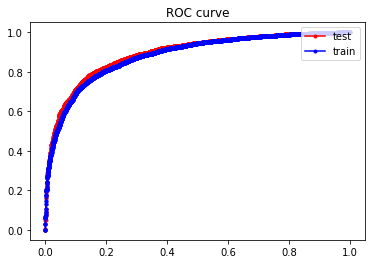

Confusion matrix for train data


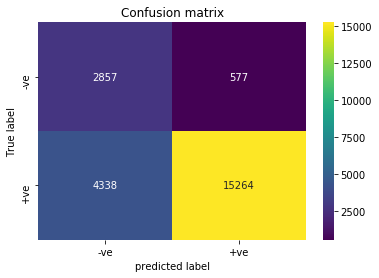

Confusion matrix for test data


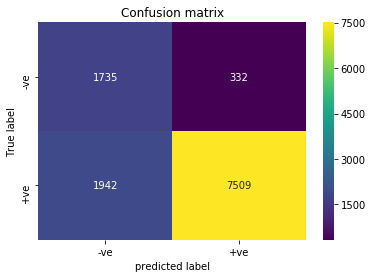

In [22]:
test(avg_w2v_train,avg_w2v_cv,avg_w2v_test,y_train_,y_cv_,y_test_,100,'l1')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


opt c:  1


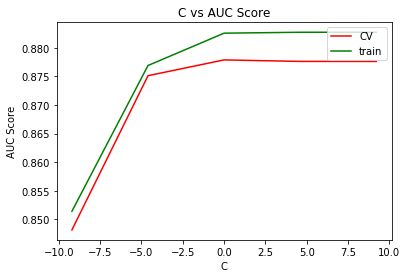

In [23]:
# Please write all the code with proper documentation
model(avg_w2v_train,avg_w2v_cv,avg_w2v_test,y_train_,y_cv_,y_test_,'l2')

AUC Score: 0.8912406245602493


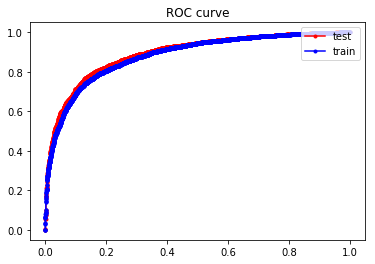

Confusion matrix for train data


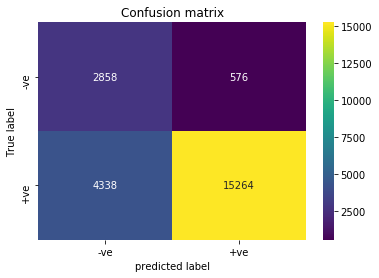

Confusion matrix for test data


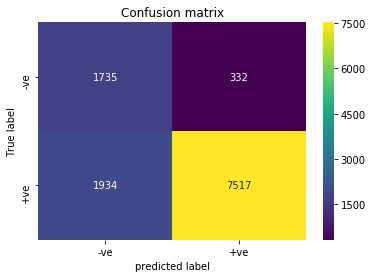

In [24]:
test(avg_w2v_train,avg_w2v_cv,avg_w2v_test,y_train_,y_cv_,y_test_,1,'l2')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
model_ = TfidfVectorizer()
tf_idf_matrix = model_.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_.get_feature_names(), list(model_.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
def vectorizer_W2V_tfidf(data):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(data): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors


In [27]:
# vectorize all train, test and cv data
tfidf_w2v_train = vectorizer_W2V_tfidf(X_train)
tfidf_w2v_cv = vectorizer_W2V_tfidf(X_cv)
tfidf_w2v_test = vectorizer_W2V_tfidf(X_test)

100%|██████████| 11518/11518 [03:00<00:00, 80.86it/s]


100%|██████████| 5/5 [01:02<00:00, 14.06s/it]


opt c:  1


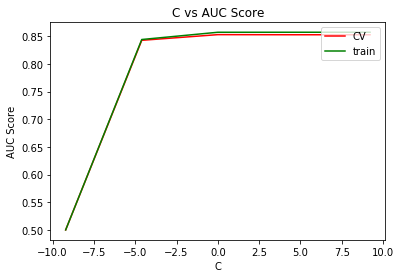

In [28]:
# Please write all the code with proper documentation
model(tfidf_w2v_train,tfidf_w2v_cv,tfidf_w2v_test,y_train_,y_cv_,y_test_,'l1')

AUC Score: 0.8630043884334635


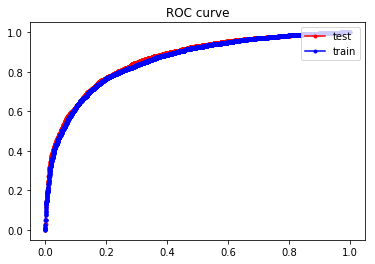

Confusion matrix for train data


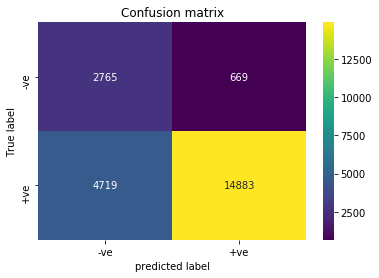

Confusion matrix for test data


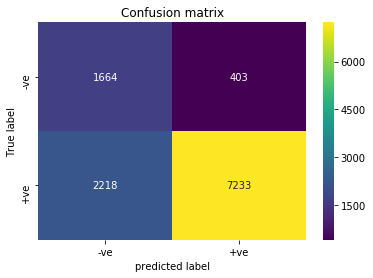

In [29]:
test(tfidf_w2v_train,tfidf_w2v_cv,tfidf_w2v_test,y_train_,y_cv_,y_test_,1,'l1')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


opt c:  1


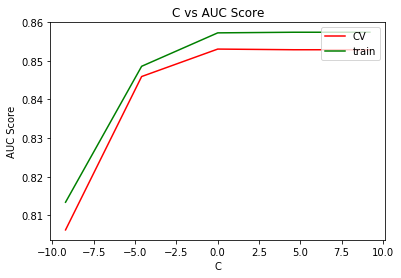

In [30]:
# Please write all the code with proper documentation
model(tfidf_w2v_train,tfidf_w2v_cv,tfidf_w2v_test,y_train_,y_cv_,y_test_,'l2')

AUC Score: 0.8629505881608583


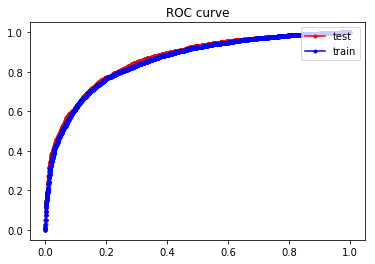

Confusion matrix for train data


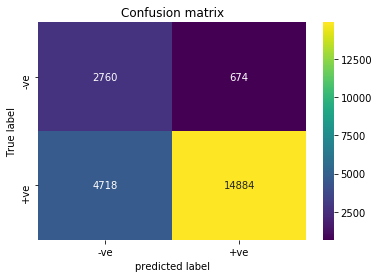

Confusion matrix for test data


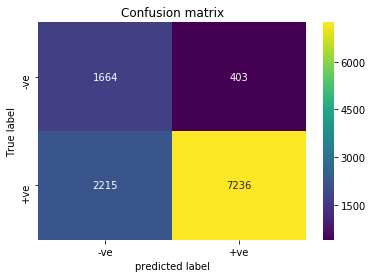

In [31]:
test(tfidf_w2v_train,tfidf_w2v_cv,tfidf_w2v_test,y_train_,y_cv_,y_test_,1,'l2')

# [6] Conclusions

In [32]:
# Please compare all your models using Prettytable library
df = pd.DataFrame({"Model":["BOW with L1 reg","BOW with L2 reg","TFIDF with L1 reg",
									"TFIDF with L2 reg","AVG W2V with L1 reg","AVG W2V with L2 reg",
									"TFIDF W2V with L1 reg","TFIDF W2V with L2 reg"],
                   "Hyper parameter(C)":[1,1,10000,100,100,1,1,1],
                   "AUC":[0.9369424958379555,0.9380411030653437,
							0.9488801245972146,0.9459927860734667,0.8911467940182082,
							0.8912406245602493,0.8630043884334635, 0.8629505881608583]}
                  ,columns=["Model","Hyper parameter(C)","AUC"])
df.sort_values(by="AUC",ascending=False)

,Model,Hyper parameter(C),AUC
2,TFIDF with L1 reg,10000,0.948880
3,TFIDF with L2 reg,100,0.945993
1,BOW with L2 reg,1,0.938041
0,BOW with L1 reg,1,0.936942
5,AVG W2V with L2 reg,1,0.891241
4,AVG W2V with L1 reg,100,0.891147
6,TFIDF W2V with L1 reg,1,0.863004
7,TFIDF W2V with L2 reg,1,0.862951


As from above table TFIDF W2V has the worst performance compared to others and TFIDF perform better than other models.


